In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from random import random
import numpy as np
import scipy.linalg
from vispy import app, gloo
import OpenGL.GL as gl
app.use_app('PyQt5') # for ubuntu 18.04

<Vispy app, wrapping the PyQt5 GUI toolkit>

In [19]:
# GLSL constant defifition
VERTEX_SHADER_BASIC = """
uniform mat4 u_mv;
uniform mat4 u_mvp;
uniform vec3 u_light_eye_position;
attribute vec3 a_position;
attribute vec3 a_color;
varying vec4 v_color;
varying vec3 v_eye_position;
varying vec3 v_light;
void main() {
    // Projected position:
    gl_Position = u_mvp * vec4(a_position, 1.0);
    // Vertex color (varying):
    v_color = vec4(a_color, 1.0);
    // Vertex position in eye/camera coordinates:
    v_eye_position = (u_mv * vec4(a_position, 1.0)).xyz;
    // Vector to the light:
    v_light = normalize(u_light_eye_position - v_eye_position);
}
"""

FRAGMENT_SHADER_COLOR = """
uniform float u_light_ambient;
varying vec4 v_color;
varying vec3 v_eye_position;
varying vec3 v_light;
void main() {
    // Face normal in eye coordinates:
    vec3 face_normal = normalize(cross(dFdx(v_eye_position), dFdy(v_eye_position)));
    // Light received by the surface (ambient + diffuse):
    float light_diffuse_w = max(dot(normalize(v_light), normalize(face_normal)), 0.0);
    float light_w = u_light_ambient + light_diffuse_w;
    light_w = clamp(light_w, 0.0, 1.0); // Clamp/clip brightness factor
    gl_FragColor = light_w * v_color;
}
"""

FRAGMENT_SHADER_DEPTH = """
uniform float u_light_ambient;
varying vec4 v_color;
varying vec3 v_eye_position;
varying vec3 v_light;
void main() {
    // Depth/distance between surface and eye:
    float v_eye_depth = -v_eye_position.z;
    gl_FragColor = vec4(v_eye_depth, 0.0, 0.0, 1.0);
}
"""

FRAGMENT_SHADER_NORMALS = """
uniform float u_light_ambient;
varying vec4 v_color;
varying vec3 v_eye_position;
varying vec3 v_light;
void main() {
    // Face normal in eye coordinates:
    vec3 face_normal = normalize(cross(dFdx(v_eye_position), dFdy(v_eye_position)));
    gl_FragColor = vec4((face_normal + 1.) / 2., 1.0);
}
"""

In [20]:
# compute projection matrix (mapping 3d coordinates of the object into 2d)
def convert_hz_intrinsic_to_opengl_projection(K, x0, y0, width, height, znear, zfar, flipy=False):
    """
    Convert camera parameter (Hartley-Zisserman intrinsic matrix) into a projection matrix for OpenGL.
    Snippet by Andrew Straw
    (https://gist.github.com/astraw/1341472/c5f8aba7f81431967d1fc9d954ae20822c616c17#file-calib_test_utils-py-L67)
    :param K:       Camera matrix
    :param x0:      Camera horizontal image origin (typically 0)
    :param y0:      Camera vertical image origin (typically 0)
    :param width:   Canvas width
    :param height:  Canvas height
    :param znear:   Clip-near value
    :param zfar:    Clip-far value
    :param flipy:   Flag to True if images should be rendered upside-down (to match other pixel coordinate systems)
    :return:        Camera projection matrix
    """
    znear = float(znear)
    zfar = float(zfar)
    depth = zfar - znear
    q = -(zfar + znear) / depth
    qn = -2 * (zfar * znear) / depth

    if not flipy:
        proj = np.array([[2 * K[0, 0] / width, -2 * K[0, 1] / width, (-2 * K[0, 2] + width + 2 * x0) / width, 0],
                         [0, -2 * K[1, 1] / height, (-2 * K[1, 2] + height + 2 * y0) / height, 0],
                         [0, 0, q, qn],  # This row is standard glPerspective and sets near and far planes.
                         [0, 0, -1, 0]])  # This row is also standard glPerspective.
    else:
        proj = np.array([[2 * K[0, 0] / width, -2 * K[0, 1] / width, (-2 * K[0, 2] + width + 2 * x0) / width, 0],
                         [0, 2 * K[1, 1] / height, (2 * K[1, 2] - height + 2 * y0) / height, 0],
                         [0, 0, q, qn],  # This row is standard glPerspective and sets near and far planes.
                         [0, 0, -1, 0]])  # This row is also standard glPerspective.
    return proj.T



In [26]:
def fibonacci_sphere(radius=20., samples=1, randomize=True):
    """ Yields 3D cartesian coordinates of pseudo-equidistributed points on the surface of a sphere of given radius,
    aligned on the origin, using Fibonacci Sphere algorithm.
    (evenly distributing points around a sphere)
    Gist from Snord (http://stackoverflow.com/a/26127012/624547)
    @yield 3D point
    """
    rnd = 1.
    if randomize:
        rnd = random() * samples

    offset = 2./samples
    increment = np.pi * (3. - np.sqrt(5.))

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2)
        r = np.sqrt(1 - pow(y, 2))

        phi = ((i + rnd) % samples) * increment

        x = np.cos(phi) * r
        z = np.sin(phi) * r

        yield [radius * x, radius * y, radius * z]


In [22]:
class Mesh():
    """
    Simplified object defining a 3D mesh.
    Snippet by:
    - Wadim Kehl (https://github.com/wadimkehl/ssd-6d/blob/master/rendering)
    """
    def __init__(self, vertices, faces, vertex_colors=None,
                 attribute_position_name='a_position', attribute_color_name='a_color'):

        self.vertices = vertices
        self.faces = faces
        self.vertex_colors = vertex_colors
        # Collate vertex data (postion and opt. color):
        vertices_type = [(attribute_position_name, np.float32, 3)]
        vertex_data = np.asarray(vertices)
        if vertex_colors is not None:
            vertices_type += [(attribute_color_name, np.float32, 3)]
            vertex_data = np.asarray(list(zip(vertices, vertex_colors)), vertices_type)

        # Buffers
        self.vertex_buffer = gloo.VertexBuffer(vertex_data)
        self.index_buffer = gloo.IndexBuffer(faces.flatten().astype(np.uint32))

    @staticmethod
    def from_ply(filename, default_color=None):
        """
        Parse a .ply file to extract the mesh information.
        :param filename:       File to parse
        :param default_color:  Default color for the mesh surface (optional)
        :return:               List of vertices, list of faces, list of vertex colors
        """
        # Read .ply file:
        ply_data = PlyData.read(filename)
        faces = np.vstack(ply_data['face'].data['vertex_indices'])
        vertices = np.stack(
            [ply_data['vertex'].data['x'], ply_data['vertex'].data['y'], ply_data['vertex'].data['z']],
            axis=-1).astype(np.float32)
        if 'blue' in ply_data['vertex']._property_lookup:   # has colors
            vertex_colors = np.stack(
                [ply_data['vertex'].data['blue'], ply_data['vertex'].data['green'], ply_data['vertex'].data['red']],
                axis=-1).astype(np.float32) / 255.
        elif default_color is not None:
            vertex_colors = np.tile(default_color, [vertices.shape[0], 1])
        else:
            vertex_colors = None
        mesh = Mesh(vertices, faces, vertex_colors)
        return mesh

In [23]:
class Camera():
    """
    Object containing the intrinsic parameters of a camera
    """
    def __init__(self, fx, fy, cx, cy, image_size, skew=0):
        """
        Initialize the camera.
        :param fx:          Horizontal focal length (in px)
        :param fy:          Vertical focal length (in px)
        :param cx:          Horizontal principal point offset (in px)
        :param cy:          Vertical principal point offset (in px)
        :param image_size:  Canvas/image size (in px)
        :param skew:        (opt.) Axis skew factor
        """

        # Camera matrix:
        self.K = np.identity(3)
        self.K[0, 0] = fx
        self.K[1, 1] = fy
        self.K[0, 2] = cx
        self.K[1, 2] = cy
        self.K[0, 1] = skew

        self.image_size = image_size

    @staticmethod
    def look_at(camera_position, target_position, roll_angle=0):
        """
        Return the rotation matrix so that the camera faces the target.
        Snippet by Wadim Kehl (https://github.com/wadimkehl/ssd-6d/blob/master/rendering)
        :param camera_position:     Camera position/translation
        :param target_position:     Target position
        :param roll_angle:          Roll angle (in degrees)
        :return:                    4x4 transformation matrix
        """
        eye_direction = target_position - camera_position
        # Compute what is the "up" vector of the camera:
        if eye_direction[0] == 0 and eye_direction[1] == 0 and eye_direction[2] != 0:
            up = [-1, 0, 0]
        else:
            up = [0, 0, 1]

        # Compute rotation matrix:
        rotation_matrix = np.zeros((3, 3))
        rotation_matrix[:, 2] = -eye_direction / np.linalg.norm(eye_direction)  # View direction towards origin
        rotation_matrix[:, 0] = np.cross(rotation_matrix[:, 2], up)  # Camera-Right
        rotation_matrix[:, 0] /= np.linalg.norm(rotation_matrix[:, 0])
        rotation_matrix[:, 1] = np.cross(rotation_matrix[:, 2], rotation_matrix[:, 0])  # Camera-Down
        rotation_matrix = rotation_matrix.T

        # Apply roll rotation using Rodrigues' formula + set position accordingly:
        rodriguez = np.asarray([0, 0, 1]) * (roll_angle * np.pi / 180.0)
        angle_axis = scipy.linalg.expm(np.cross(np.eye(3), rodriguez))
        rotation_matrix = np.dot(angle_axis, rotation_matrix)

        transform_matrix = np.eye(4)
        transform_matrix[0:3, 0:3] = rotation_matrix
        transform_matrix[0:3, 3] = [0, 0, scipy.linalg.norm(camera_position)]
        return transform_matrix

In [24]:
# canvas from vispy
class MeshRenderer(app.Canvas):
    """
    Vispy renderer for single meshes
    Inspired from snippets by:
    - Wadim Kehl (https://github.com/wadimkehl/ssd-6d/blob/master/rendering/renderer.py)
    - Tomas Hodan (https://github.com/thodan/t-less_toolkit/blob/master/pytless/renderer.py)
    """
    def __init__(self, camera, mesh,
                 vertex_shader=VERTEX_SHADER_BASIC, fragment_shader=FRAGMENT_SHADER_COLOR,
                 clip_near=100.0, clip_far=700.0,
                 background_color=(.0, .0, .0),
                 ambient_light=0.15, directional_light_vector=[0., 0., 0.]):
        """
        Initialize the mesh renderer
        :param camera:                      Camera instance
        :param mesh:                        Mesh containing vertices and faces (e.g. fom PyMesh)
        :param vertex_shader:               Vertex shader code
        :param fragment_shader:             Fragment shader code
        :param clip_near:                   Clip-near value (elements closer than this won't be rendered)
        :param clip_far:                    Clip-far value (elements farther than this won't be rendered)
        :param background_color:            Background color
        :param ambient_light:               Ambient light factor
        :param directional_light_vector:    Vector of directional light
        """

        # Initialize Vispy canvas:
        app.Canvas.__init__(self, show=False, size=camera.image_size)

        self.shape = (camera.image_size[1], camera.image_size[0])
        self.camera = camera
        self.mesh = mesh
        self.background_color = background_color
        self.ambient_light = ambient_light
        self.directional_light_vector = np.asarray(directional_light_vector)
        self.clip_near = clip_near
        self.clip_far = clip_far

        # OpenGL shader program:
        self.gl_program = gloo.Program(vertex_shader, fragment_shader)

        # Matrix to convert to OpenGL camera system (flipping Y-Z axes):
        self.yz_flip = np.eye(4, dtype=np.float32)
        self.yz_flip[1, 1], self.yz_flip[2, 2] = -1, -1

        # Model matrix (defining the mesh/model pose):
        self.model_matrix = np.eye(4, dtype=np.float32)

        # Projection matrix:
        self.projection_matrix = convert_hz_intrinsic_to_opengl_projection(
            camera.K, 0, 0, camera.image_size[0], camera.image_size[1], clip_near, clip_far, False)

        # Texture to render the image into:FBO
        self.image_texture = gloo.Texture2D(shape=self.shape + (3,))

        # Corresponding FBO (frame buffer):
        self.fbo = gloo.FrameBuffer(self.image_texture, gloo.RenderBuffer(self.shape))
        self.fbo.activate()
        # Drawing parameters (face culling, background color, viewport size, etc.):
        gloo.set_state(depth_test=True, blend=False, cull_face=False)
        gloo.set_clear_color(background_color)
        gloo.set_viewport(0, 0, *self.size)

        # Manually updating the state of the hidden canvas:
        # self.update()

    def draw(self, camera_translation_vector, camera_rotation_matrix, return_depth=True):
        """
        Render and return color and optionally depth images of the mesh, from the chosen viewpoint.
        :param camera_translation_vector:   Camera position
        :param camera_rotation_matrix:      Camera rotation
        :param return_depth:                Flag to return depth modality
        :return:                            RGB image, opt. depth image
        """

        # View matrix (defining the camera pose):
        view_matrix = np.eye(4, dtype=np.float32)
        view_matrix[:3, 3] = np.squeeze(camera_translation_vector)
        view_matrix[:3, :3] = camera_rotation_matrix

        # Converting it to OpenGL coordinate system:
        view_matrix = self.yz_flip.dot(view_matrix).T

        # Model-view matrix (projecting from object space to camera space):
        mv_matrix = np.dot(self.model_matrix, view_matrix)

        # Model-view-projection matrix (projecting from object space to image space):
        mvp_matrix = np.dot(mv_matrix, self.projection_matrix)

        # Clear previous content:
        gloo.clear(color=True, depth=True)
        # Bind mesh buffer to shader program:
        self.gl_program.bind(self.mesh.vertex_buffer)
        # Pass parameters to shader program:
        self.gl_program['u_mv'] = mv_matrix
        self.gl_program['u_mvp'] = mvp_matrix
        self.gl_program['u_light_eye_position'] = self.directional_light_vector
        self.gl_program['u_light_ambient'] = self.ambient_light
        # Render:
        self.gl_program.draw('triangles', self.mesh.index_buffer)

        # Fetch rendered content from FBO:
        bgr = np.copy(gloo.read_pixels((0, 0, self.shape[1], self.shape[0]))[..., :3])
        rgb = bgr[..., ::-1]

        if return_depth:
            z_buffer = gl.glReadPixels(0, 0, self.shape[1], self.shape[0], gl.GL_DEPTH_COMPONENT, gl.GL_FLOAT)
            # Convert buffer into array and flip axis:
            z_buffer = np.copy(np.frombuffer(z_buffer, np.float32)).reshape(self.shape + (1,))[::-1, :]
            # Convert buffer values into depth map:
            depth_coef = (self.clip_near * self.clip_far) / (self.clip_near - self.clip_far)
            z_offset = self.clip_far / (self.clip_near - self.clip_far)
            background_mask = z_buffer == 1.
            depth = depth_coef / (z_buffer + z_offset)
            depth[background_mask] = 0.
            return rgb, depth
        else:
            return rgb

    def crop_image_around_vertex(self, image, vertex, crop_dimensions_in_m=(0.2, 0.2), scale=1):
        """
        Crop a patch from the image around the given 3D point.
        :param image:                   Image to be cropped
        :param vertex:                  3D points to crop around
        :param crop_dimensions_in_m:    Size of the patch around the given point, in meters
        :param scale:                   Scale of the model (1 by default)
        :return:                        Cropped image
        """

        # Convert crop dimensions from real-world to image space:
        crop_dimensions_in_px = self.camera.K[[0,1], [0,1]] * crop_dimensions_in_m / scale

        # Project vertex (i.e., the crop center) in camera space:
        projected_vertex = np.dot(self.camera.K, vertex)
        projected_vertex = projected_vertex[:2] / projected_vertex[2]

        # Compute crop corners:
        crop_top_left     = (projected_vertex - crop_dimensions_in_px // 2).astype(np.int32)
        crop_bottom_right = (projected_vertex + crop_dimensions_in_px // 2).astype(np.int32)

        crop_top_left[0] = np.clip(crop_top_left[0], 0, self.shape[1])
        crop_top_left[1] = np.clip(crop_top_left[1], 0, self.shape[0])
        crop_bottom_right[0] = np.clip(crop_bottom_right[0], 0, self.shape[1])
        crop_bottom_right[1] = np.clip(crop_bottom_right[1], 0, self.shape[0])

        # Crop image accordingly:
        crop = image[crop_top_left[1]:crop_bottom_right[1], crop_top_left[0]:crop_bottom_right[0]]
        return crop

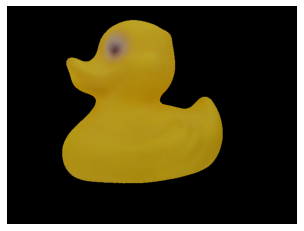

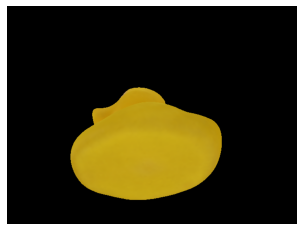

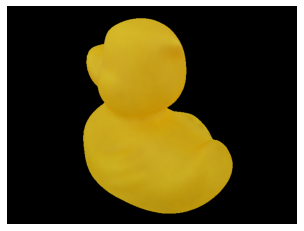

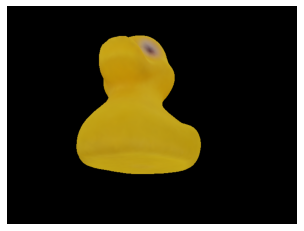

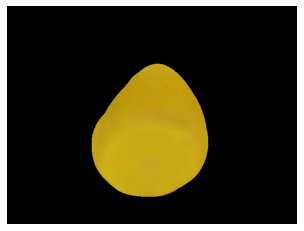

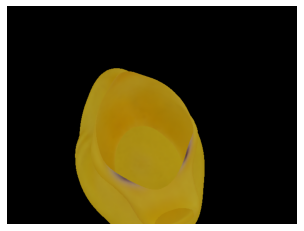

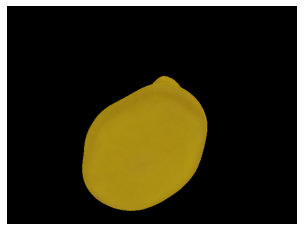

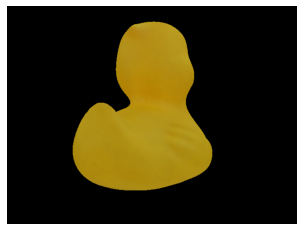

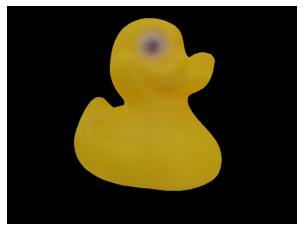

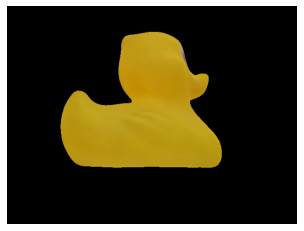

In [25]:
# main
if __name__ == "__main__":
    # import pymesh
    # !pip install plyfile
    from plyfile import PlyData
    import matplotlib.pyplot as plt

    # Mesh:
    duck_mesh = Mesh.from_ply("res/linemod/duck/mesh.ply")
    # duck_mesh = Mesh.from_ply("res/chair.ply")

    # Camera (simulating Microsoft Kinect camera used to capture original LineMOD dataset):
    # values changed fro ubuntu pyQt5
    kinect_cam = Camera(572.4114, 573.5704, 305.2611, 132.0489, (640, 480))

    # Renderer:
    duck_renderer = MeshRenderer(kinect_cam, duck_mesh)
    duck_position = duck_renderer.model_matrix[:3, 3]

    # Move the camera on a sphere around the object and capture/crop images:
    crop_dimensions = [0.40, 0.40]
    for camera_position in fibonacci_sphere(radius=170, samples=10, randomize=False):
        camera_transform_matrix = Camera.look_at(camera_position, duck_position)
        camera_position = camera_transform_matrix[0:3, 3]
        camera_rotation_matrix = camera_transform_matrix[0:3, 0:3]

        # Randomize lighting conditions:
        duck_renderer.ambient_light = np.random.uniform(0.75, 0.90)
        duck_renderer.directional_light_vector = np.random.uniform(-1, 1, size=3)

        rgb_image, depth_image = duck_renderer.draw(camera_position, camera_rotation_matrix, return_depth=True)

        plt.imshow(rgb_image)
        plt.axis("off")
        plt.show()